Current competition metric implies segmenation task. However one valid approach could incorporate object detection. In this direcrion and borrowing stuff from Kevin's excellent kernel [https://www.kaggle.com/kmader/baseline-u-net-model-part-1](http://), we attempt to extract bounding boxes information from binary rle-encoded masks.
And produce correspoding CSV file for tensorflow training 
This kernal is a small derivative from Costas Voglis kernal [https://www.kaggle.com/voglinio/from-masks-to-bounding-boxes](http://,)

In [5]:
import os
import cv2
import csv
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util.montage import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '/media/artidokuz/EXTERNAL/Ham Veri/airbus-ship'
train_image_dir = os.path.join(ship_dir, 'train')
test_image_dir = os.path.join(ship_dir, 'test')

from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

Let us read the masks:

In [6]:
masks = pd.read_csv('train_ship_segmentations.csv')
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

131030 masks found
104070


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


and keep only those that contain ships. Keep in mind that image files can be repeated many times in the csv file. So a unique operator will give us the unique filenames that contain ships.

In [7]:
images_with_ship = masks.ImageId[masks.EncodedPixels.isnull()==False]
images_with_ship = np.unique(images_with_ship.values)
print('There are ' +str(len(images_with_ship)) + ' image files with masks')

There are 29070 image files with masks


In order to extract the bounding box we:
1. Load mask as binary numpy array using Kevin's `masks_as_image`)

2. Label  connected regions of this mask using `skimage.measure.label`

3. Measure morphological properties of these connected regions and keep the bounding box (`skimage.measure.regionprops`). For each connected region a bounding box of the form  (min_row, min_col, max_row, max_col) is returned.  


Image 000155de5.jpg
Found bbox (465, 344, 501, 448)


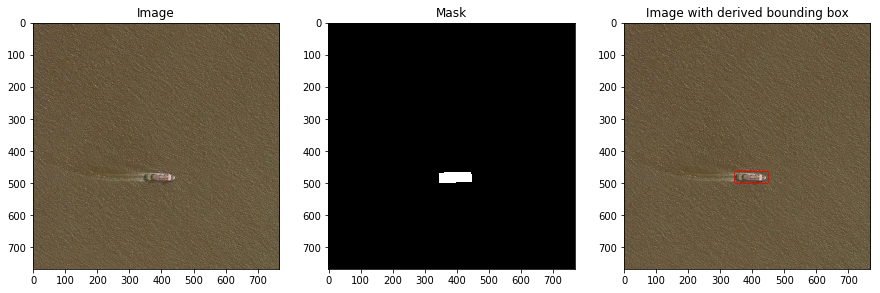

Image 00021ddc3.jpg
Found bbox (705, 96, 720, 121)
Found bbox (732, 123, 768, 178)
Found bbox (629, 181, 638, 187)
Found bbox (661, 195, 665, 201)


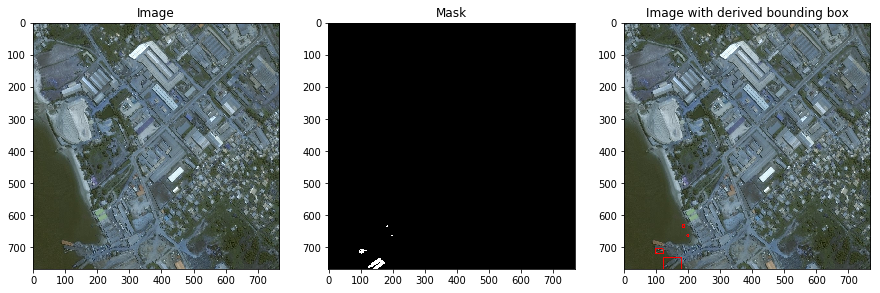

Image 0002756f7.jpg
Found bbox (36, 324, 67, 351)


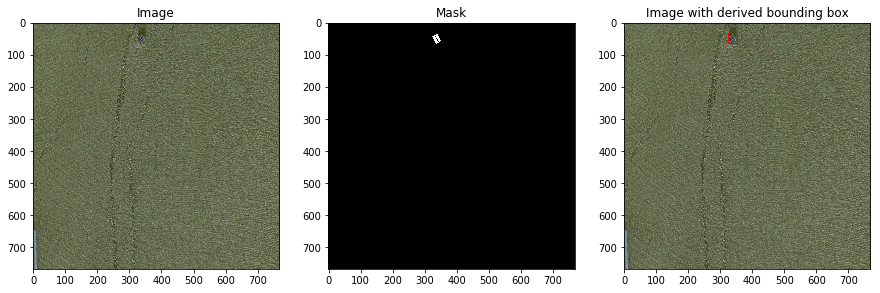

Image 00031f145.jpg
Found bbox (124, 443, 153, 472)


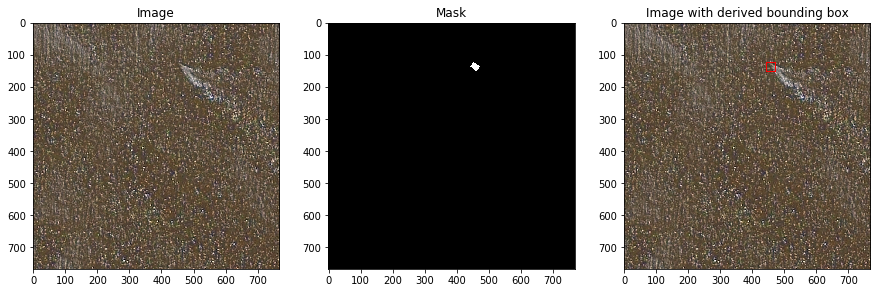

Image 00053c6ba.jpg
Found bbox (124, 736, 139, 752)


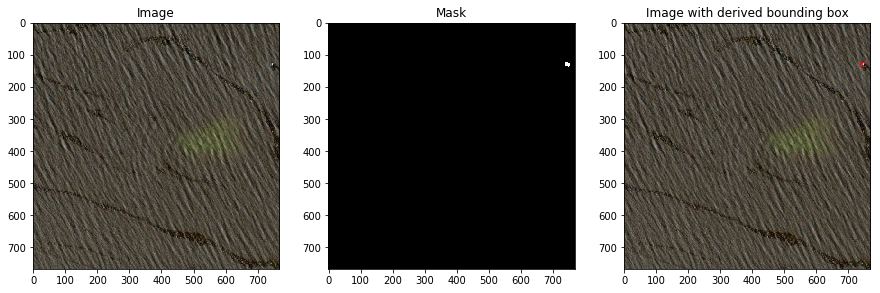

Image 0005d01c8.jpg
Found bbox (598, 72, 739, 237)
Found bbox (252, 476, 321, 556)


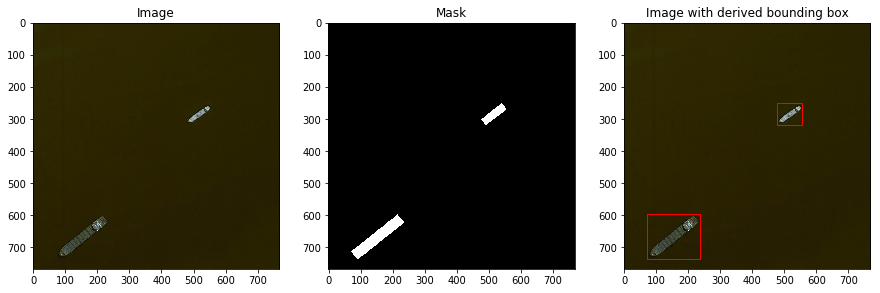

Image 0006c52e8.jpg
Found bbox (197, 190, 472, 407)


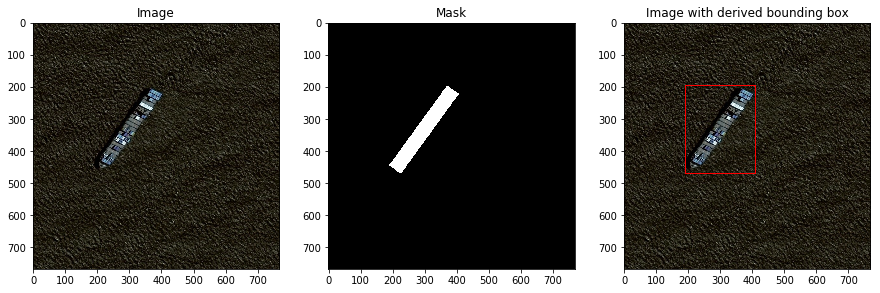

Image 000d42241.jpg
Found bbox (583, 480, 588, 488)


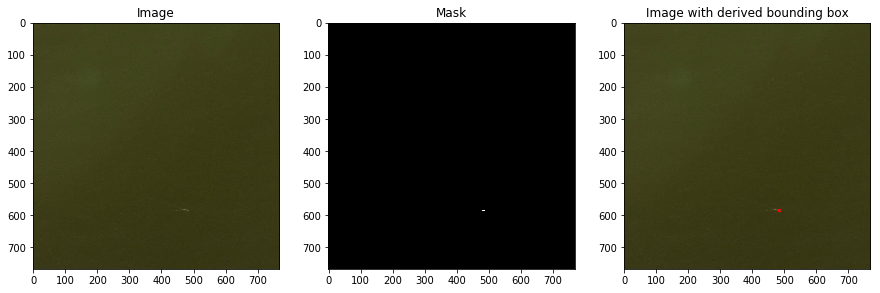

Image 000e6378b.jpg
Found bbox (401, 292, 422, 325)


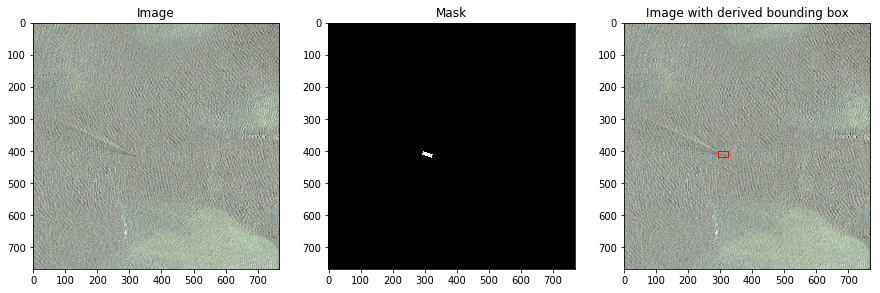

Image 000fd9827.jpg
Found bbox (259, 69, 276, 85)


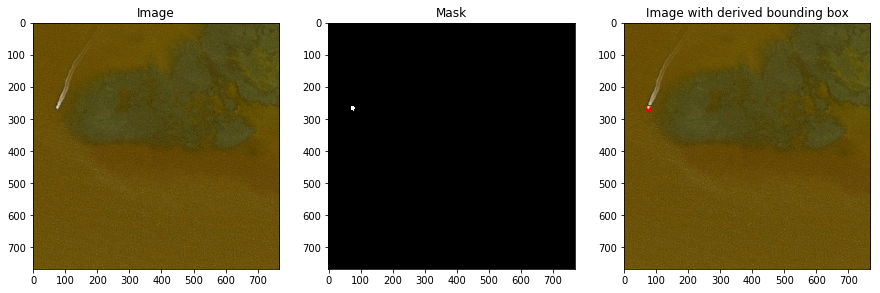

In [8]:
for i in range(10):
    image = images_with_ship[i]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
    img_0 = cv2.imread(train_image_dir+'/' + image)
    rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    #
    # 
    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    img_1 = img_0.copy()
    print ('Image', image)
    for prop in props:
        print('Found bbox', prop.bbox)
        cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)


    ax1.imshow(img_0)
    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax3.set_title('Image with derived bounding box')
    ax2.imshow(mask_0[...,0], cmap='gray')
    ax3.imshow(img_1)
    plt.show()

Here we calculate the bounding boxes for all `29070` images and save then into a dictionary. 

In [9]:
import gc 
bboxes_dict = {}
i = 0
count_ships = 0
for image in tqdm(images_with_ship):
    img_0 = cv2.imread(train_image_dir+'/' + image)
    rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)

    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    bboxes = []
    count_ships = count_ships + len(props)
    for prop in props:
        bboxes.append(prop.bbox)
        
        
    i = i + 1
    if i % 500 == 0:
        gc.collect()    

    bboxes_dict[image] = bboxes.copy()

100%|██████████| 29070/29070 [27:36<00:00, 27.63it/s]  


Let us save extracted bounding boxes in CSV file 

In [10]:
dict_images = list(bboxes_dict.keys())
myData = [['image_name','width','height','class','xmin','ymin','xmax','ymax']]
myFile = open('train1.csv', 'w')
with myFile:
            writer = csv.writer(myFile)
            writer.writerows(myData)
for i in range(29070):
    image = dict_images[i]
    img_0 = cv2.imread(train_image_dir+'/' + image)
    rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    img_1 = img_0.copy()
    bboxs = bboxes_dict[image]
    width, height = img_1.shape[:2]
    for bbox in bboxs:
        cv2.rectangle(img_1, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (255, 0, 0), 2)
        myData = [[image,width,height,'ship',bbox[1], bbox[0], bbox[3], bbox[2]]]
        with open('train1.csv','a',newline='') as myFile:
            writer = csv.writer(myFile)
            writer.writerows(myData)

AttributeError: 'NoneType' object has no attribute 'copy'